# Import

In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table
from scipy.interpolate import interp1d

# Data

### Reading Header

In [2]:
# Printing header

file_path = 'HETspec/PSU22-2-010/spectrum_20220325_0000008_exp01_red.fits'

with fits.open(file_path) as hdul:
    header = hdul[0].header

print(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2064                                                  NAXIS2  =                    6                                                  EXTEND  =                    T                                                  DATE    = '2022-03-25T07:07:26.715785'                                          DATE-OBS= '2022-03-25'                                                          TELESCOP= 'het     '                                                            INSTRUME= 'lrs2    '                                                            OBJECT  = 'BBH019_056_W'                                                        OBSERVER= ''                                                                    TELRA   = '+09:51:53.5'                 

### Reading data 

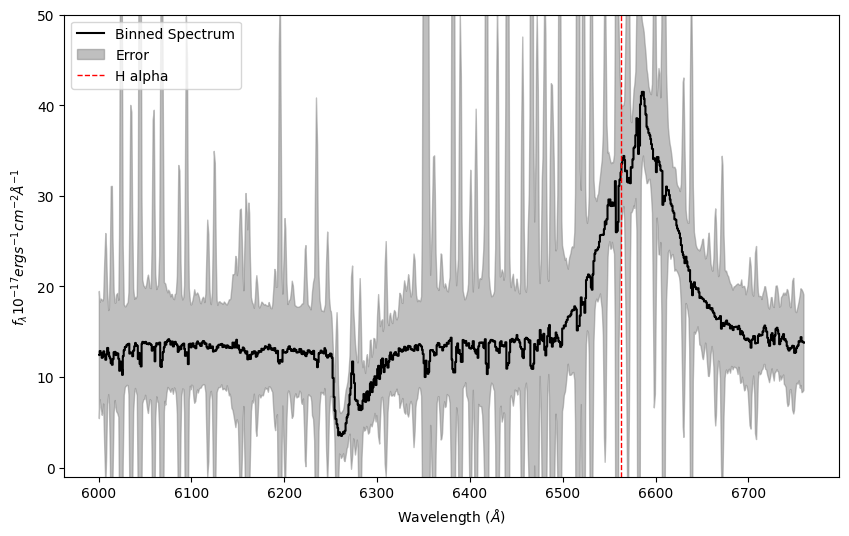

In [3]:
def read_spectrum(file_path, z):
    with fits.open(file_path) as hdul:
        data = hdul[0].data
    wl = data[0] / (1 + z)
    flux = data[1] * 1e17
    e_flux = data[2] * 1e17
    return wl, flux, e_flux

# File paths and redshift
file_path_farred = 'HETspec/PSU22-2-010/spectrum_20220325_0000009_exp01_farred.fits'
file_path_other = 'HETspec/PSU22-2-010/spectrum_20220325_0000009_exp01_red.fits'
z = 0.2144

# Read both spectra
wl_farred, flux_farred, e_flux_farred = read_spectrum(file_path_farred, z)
wl_other, flux_other, e_flux_other = read_spectrum(file_path_other, z)

# Combine the data
wl_combined = np.concatenate((wl_farred, wl_other))
flux_combined = np.concatenate((flux_farred, flux_other))
e_flux_combined = np.concatenate((e_flux_farred, e_flux_other))

# Bin the combined data
bin_width = 1
bins = np.arange(min(wl_combined), max(wl_combined) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
indices = np.digitize(wl_combined, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl_combined[in_bin]))
        binned_flux.append(np.mean(flux_combined[in_bin]))
        binned_flux_err.append(np.mean(e_flux_combined[in_bin]))

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

# Apply mask to keep only values between 6000 Å and 7000 Å
mask = (binned_wl >= 6000) & (binned_wl <= 6760)
binned_wl_masked = binned_wl[mask]
binned_flux_masked = binned_flux[mask]
binned_flux_err_masked = binned_flux_err[mask]

# Plotting the combined spectrum with the mask applied
plt.figure(figsize=(10, 6))
plt.plot(binned_wl_masked, binned_flux_masked, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl_masked, binned_flux_masked - binned_flux_err_masked, binned_flux_masked + binned_flux_err_masked, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6562.819, color='r', linestyle='--', linewidth=1, label="H alpha")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.ylim(-1, 50)
plt.legend()
plt.show()


### Reading the standard

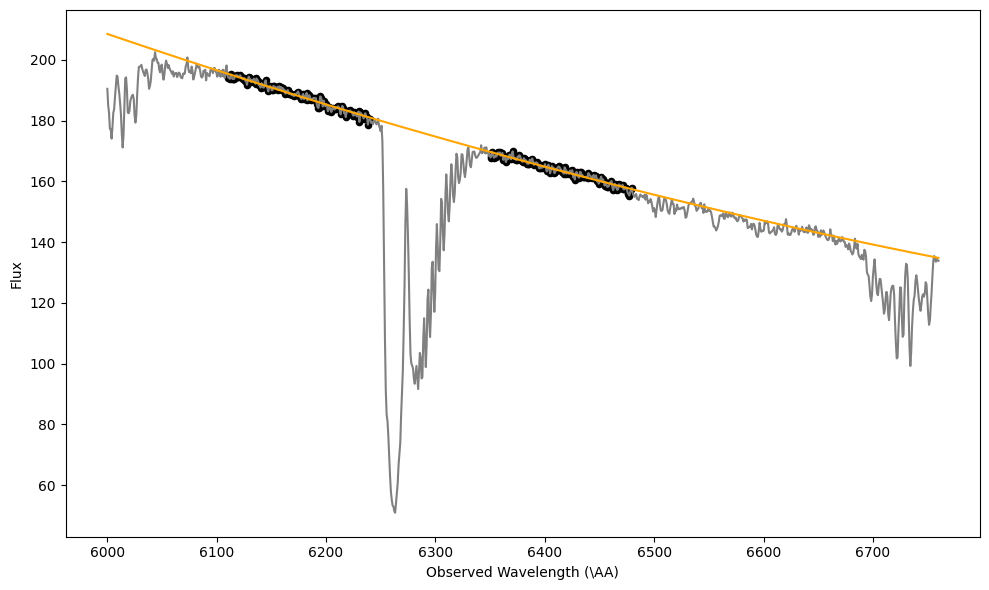

In [4]:
file_name = 'bundle_20230529_standards/spectrum_20220321_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header


z = 0.2144

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 6760))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6000) | (wl_o > 6110))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6240) | (wl > 6350))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6480) | (wl > 6760))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

#mask4 = np.where((wl < 7000) | (wl > 7130))
#wl = wl[mask4]
#flux = flux[mask4]
#err = err[mask4]


plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o, color='grey')
plt.scatter(wl, flux, color='black', s=20)


coefficients = np.polyfit(wl, flux, 2)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

plt.plot(wl_o, fitted_continuum, color='orange')

plt.xlabel('Observed Wavelength (\AA)')
plt.ylabel('Flux')
plt.tight_layout()
#plt.savefig("paper_figures/standard_spectra.pdf", format='pdf')
plt.show()



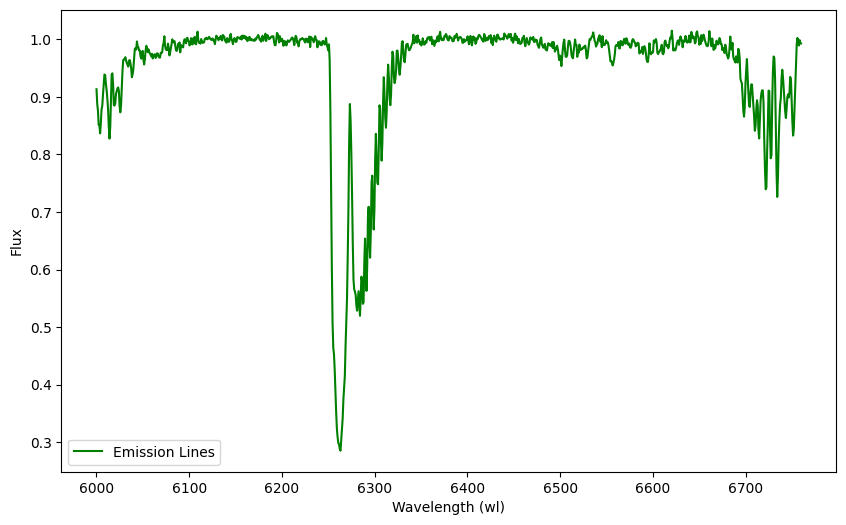

In [5]:
degree = 2

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o


plt.figure(figsize=(10, 6))
#plt.plot(wl_o, flux_o, label='Original Flux Data')
#plt.plot(wl_o, polynomial_continuum, label='Polynomial Continuum', color='orange')
plt.plot(standard_wl, standard_flux, label='Emission Lines', color='green')
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
#plt.ylim(0, 4)
plt.legend()
plt.show()

In [6]:
source_wl=binned_wl_masked
source_flux=binned_flux_masked
source_err=binned_flux_err_masked



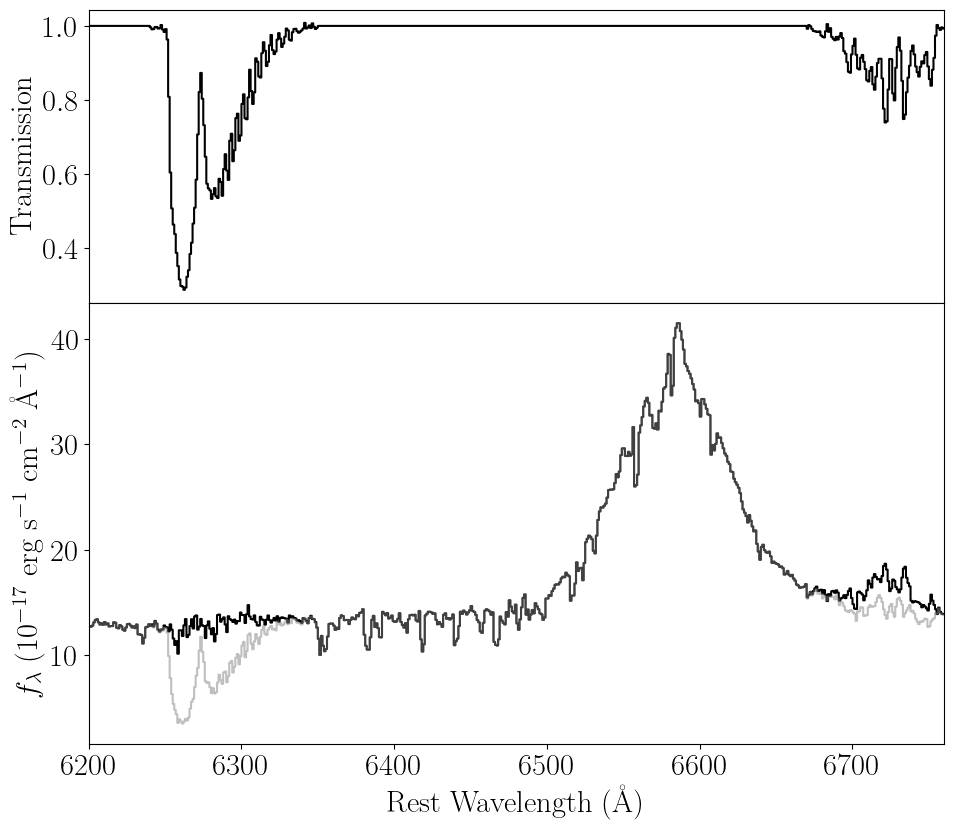

In [7]:
shift = 0
scale = 1

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1 - (1 - tmp) ** scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1 - (1 - standard_flux) ** scale)

mask1 = np.where((standard_wl > 6050) & (standard_wl < 6240))[0]
mask2 = np.where((standard_wl > 6350) & (standard_wl < 6670))[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1

bin_size = 1
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers

indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1

source_flux_binned = np.array([np.nanmean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux_binned = np.array([np.nanmean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.nanmean(source_err[indices1 == i]) for i in range(len(bin_centers))])

# Remove NaN values and corresponding wavelengths
valid_indices = ~np.isnan(source_flux_binned) & ~np.isnan(standard_flux_binned)
source_flux_binned = source_flux_binned[valid_indices]
standard_flux_binned = standard_flux_binned[valid_indices]
wavelength = wavelength[valid_indices]
binned_err = binned_err[valid_indices]

plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 1, height_ratios=[2, 3, 0], hspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
# Plotting on the first axis
ax1.plot(wavelength, standard_flux_binned, color='black', drawstyle='steps-mid')
ax1.set_ylabel('Transmission')
ax1.tick_params(labelbottom=False) 
ax1.set_xlim(6200, 6760)

# Plotting on the second axis
ax2.plot(wavelength, source_flux_binned / standard_flux_binned, color='black', label='Corrected Spectrum', drawstyle='steps-mid')
ax2.plot(wavelength, source_flux_binned, color='grey', label='Observed Spectrum', drawstyle='steps-mid', alpha=0.5)
ax2.set_xlabel('Rest Wavelength (\AA)')
ax2.set_ylabel("$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)")
ax2.set_xlim(6200, 6760)

plt.tight_layout()
plt.savefig("figures/spectrum_correction.pdf", format='pdf', bbox_inches='tight')
plt.show()

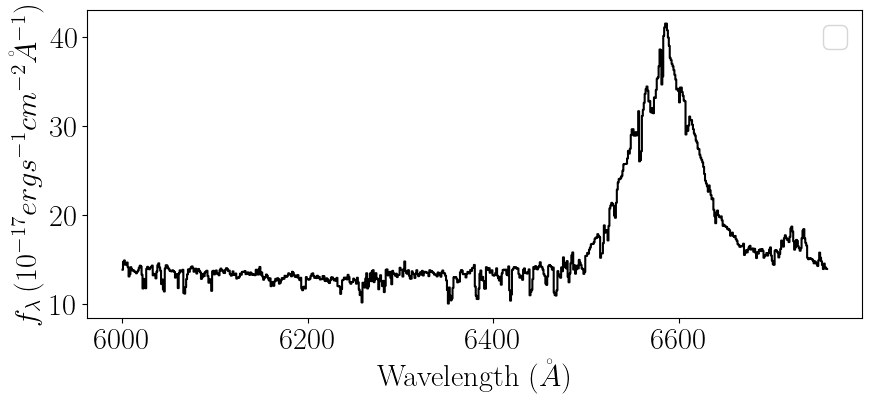

In [8]:
corrected_flux = source_flux_binned / standard_flux_binned
corrected_wl = bin_centers


plt.figure(figsize=(10, 4))
plt.plot(wavelength, corrected_flux, color="black", drawstyle='steps-mid')
#plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
#plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
#plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
#plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
#plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
#plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel("$f_{\lambda} \: (10^{-17} erg s^{-1} cm^{-2} \AA^{-1})$")
plt.legend()
plt.show()

# Functions

In [9]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [10]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [11]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [12]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,fe_s,fe_index,fe_shift,sb_s,sb_index,sb_shift,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                         nii2_f,nii2_cent,nii2_fwhm,\
                         #oi1_f,oi1_cent,oi1_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)     

    # optical Fe II template
    feii = template_fitter(x,feii_templates,fe_s,fe_index,fe_shift)
    
    # MILES stellar template
    sb = template_fitter(x,stellar_templates,sb_s,sb_index,sb_shift)

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)

    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)

    
    #oi1 = gaussian(x,oi1_f,oi1_cent,oi1_fwhm,normalized=False)
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)
    

    y = pl + feii + sb + sii1 + sii2 + halpha1 + halpha2 + nii1 + nii2
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'feii':feii,\
             'sb':sb,\
            'sii1':sii1,\
             'sii2':sii2,\
             'nii1':nii1,\
             'nii2':nii2,\
             #'oi1':oi1,\
            'halpha1':halpha1,\
            'halpha2':halpha2} 
    
    return y

In [13]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [14]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [15]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 26,
            parnames=['pl_s','pl_e','fe_s','fe_index','fe_shift','sb_s','sb_index','sb_shift',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                      'sii2_f','sii2_cent','sii2_fwhm',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                      'nii2_f','nii2_cent','nii2_fwhm',\
                      #'oi1_f','oi1_cent','oi1_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'haplha2_f','halpha2_cent','halpha2_fwhm'], 
            parlimited=[(False,False),(False,False),\
                        (False,False),(True,True),(True,True),\
                        (False,False),(True,True),(True,True),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        #(False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                       (0,0),(0,100),(-1,1),\
                       (0,0),(0,8),(-1,1),\
                      (0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [85]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii1 = model['sii1']
    sii2 = model['sii2']

    nii1 = model['nii1']
    nii2 = model['nii2']
    #oi1 = model['oi1']
    halpha1 = model['halpha1']
    halpha2 = model['halpha2']
    
    plt.rc('text', usetex=True)
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 34,
        'axes.linewidth': 2,
        'xtick.major.width': 2,
        'ytick.major.width': 2,
        'xtick.minor.width': 2,
        'ytick.minor.width': 2
    })

    fig = plt.figure(figsize=(23, 7))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=pink, linewidth=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    #ax.plot(wave,model['feii'],color=green)
    ax.plot(wave,model['sb'],color=green)
    ax.plot(wave,sii1,color=dark_orange)
    ax.plot(wave,sii2,color=dark_orange)
    ax.plot(wave,nii1,color=dark_orange)
    ax.plot(wave,nii2,color=dark_orange)
    ax.plot(wave,halpha1,color=dark_orange)
    ax.plot(wave,halpha2,color=pink)
    ax.set_xlim(wavemin,wavemax)
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_label_coords(-0.03, 0.45) 
    
    #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="both",which='both',direction="in")

    # Common y-axis label
    #fig.text(0, 0.55, r'$f_{\lambda} \:(10^{-17} \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}})$', va='center', rotation='vertical')

    plt.tight_layout()
    if HARDCOPY: fig.savefig(f'figures/{plotfile}_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    

### Setup for plotting

In [38]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

# Loading Templates

In [39]:
feii_template_path='/home/serat/Downloads/fe_op_templates.npy'
stellar_template_path='/home/serat/Downloads/PyQSOfit_MILES_templates.dat'
balmer_cont_template_path='/home/serat/Downloads/balmer_cont_templates.npy'
balmer_highorder_template_path='/home/serat/Downloads/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
num_templates_balmer_cont=20
num_templates_balmer_highorder=21

feii_templates=np.load(feii_template_path,allow_pickle=True)
stellar_templates=np.genfromtxt(stellar_template_path,skip_header=5)
balmer_cont_templates=np.load(balmer_cont_template_path,allow_pickle=True)
balmer_highorder_templates=np.load(balmer_highorder_template_path,allow_pickle=True)

# Fitting

In [40]:
flux = corrected_flux
lam = corrected_wl
err = binned_err


In [41]:
o3_off = 5007.57/5006.843

sii1 = 6718.85
sii2 = 6733.72
halpha = 6567
nii1 = 6551.06
nii2 = 6585.64
oi2 = 6370.46
oi1 = 6303.05
fevii = 6085.90

sii1_off = sii1*o3_off
sii2_off = sii2/sii1
nii1_off = nii1/sii1
nii2_off = nii2/sii1
oi1_off = oi1/sii1
oi2_off = oi2/sii1
halpha_off = halpha/sii1
fevii_off = fevii/sii1 



c = 2.99e5 # km/s

In [42]:
guesses = [5,0,\
           5.,20,0.,\
          2.,5,0.,\
          10, sii1_off, 300,\
           10, sii2, 300,\
           10, nii1, 300,\
           10, nii2, 300,\
           #0, oi1, 80,\
          10, halpha, 300,\
          30, 6590, 3000]
           
tied = ['','',\
        '','','',
        '','','',
       '', '', '',\
        'p[8]/3', 'p[9] * {0}'.format(sii2_off), 'p[10]',\
       '', 'p[9] * {0}'.format(nii1_off), 'p[10]',\
        'p[14]*3', 'p[9] * {0}'.format(nii2_off), 'p[10]',\
       '', 'p[9] * {0}'.format(halpha_off), 'p[10]',\
       #'', '', '',\
       #'p[26]/3', '', '',\
       '', '', '']


step = [0.5, 0.05,\
        0.5,0.25,0.005,\
       0.5,0.25,0.005,\
       0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
         0,0,0,\
         0,0,1,\
        0,1,0,\
         #0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0]

lmin = [True,True,\
        True,True,True,
        True,True,True,
        True,True,True,\
         True,True,True,\
         True,True,True,\
         True,True,True,\
         True,True,True,\
        True,True,True]


lmax = [True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
         True,True,True,\
         True,True,True,\
         True,True,True,\
         True,True,True,\
        True,True,True]


minp = [0,-5,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,6700,-0.05,\
        0,6000,-0.05,\
        0,6000,-0.05,\
        0,6000,-0.05,\
        0,6000,50,\
        0,6000,50]


maxp = [1e6,5,\
        1e6,99,0.05,\
        1e6,7,0.05,\
        1e6,6730,800.,\
        1e6,7000,800.,\
        1e6,7000,5000.,\
        1e6,7000,5000.,\
        1e6,7000,5000.,\
        1e6,7000,5000.]

print(len(guesses), len(maxp), len(minp), len(lmax), len(lmin), len(fixed), len(step), len(tied))


26 26 26 26 26 26 26 26


In [43]:
print(len(guesses))

26


In [44]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),len(guesses))
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,limitedmin=lmin,limitedmax=lmax,minpars=minp,maxpars=maxp,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,760 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  789.9898563  DOF =  746
   PL_S0 = 5  
   PL_E0 = 0  
   FE_S0 = 5  
   FE_INDEX0 = 20  
   FE_SHIFT0 = 0  
   SB_S0 = 2  
   SB_INDEX0 = 5  
   SB_SHIFT0 = 0  
   SII1_F0 = 10  
   SII1_CENT0 = 6719.825586  
   SII1_FWHM0 = 300  
   SII2_F0 = 3.333333333  
   SII2_CENT0 = 6734.697745  
   SII2_FWHM0 = 300  
   NII1_F0 = 10  
   NII1_CENT0 = 6552.011222  
   NII1_FWHM0 = 300  
   NII2_F0 = 30  
   NII2_CENT0 = 6586.596243  
   NII2_FWHM0 = 300  
   HALPHA1_F0 = 10  
   HALPHA1_CENT0 = 6567.953537  
   HALPHA1_FWHM0 = 300  
   HAPLHA2_F0 = 30  
   HALPHA2_CENT0 = 6590  
   HALPHA2_FWHM0 = 3000  
Iter       2    CHI-SQUARE =  469.3935496  DOF =  746
   PL_S0 = 5.385537534  
   PL_E0 = -0.04367404178  
   FE_S0 = 6.688508563  
   FE_INDEX0 = 26.28631672  
   FE_SHIFT0 = 0.0007064430724  
   SB_S0 = 2.334544994  
   SB_INDEX0 = 2.881900633  
   SB_SHIFT0 = 0  
   S

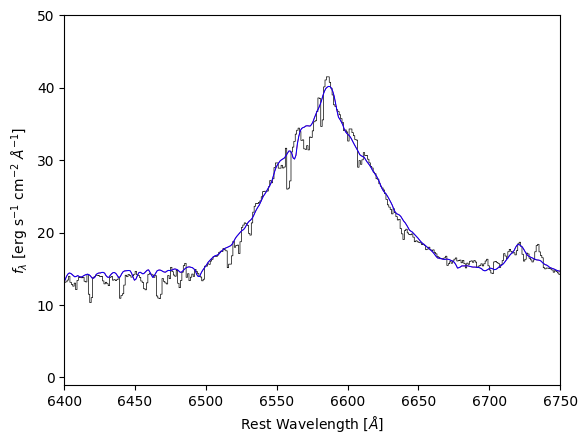

In [45]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6400,xmax=6750,ymin=-1,ymax=50,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

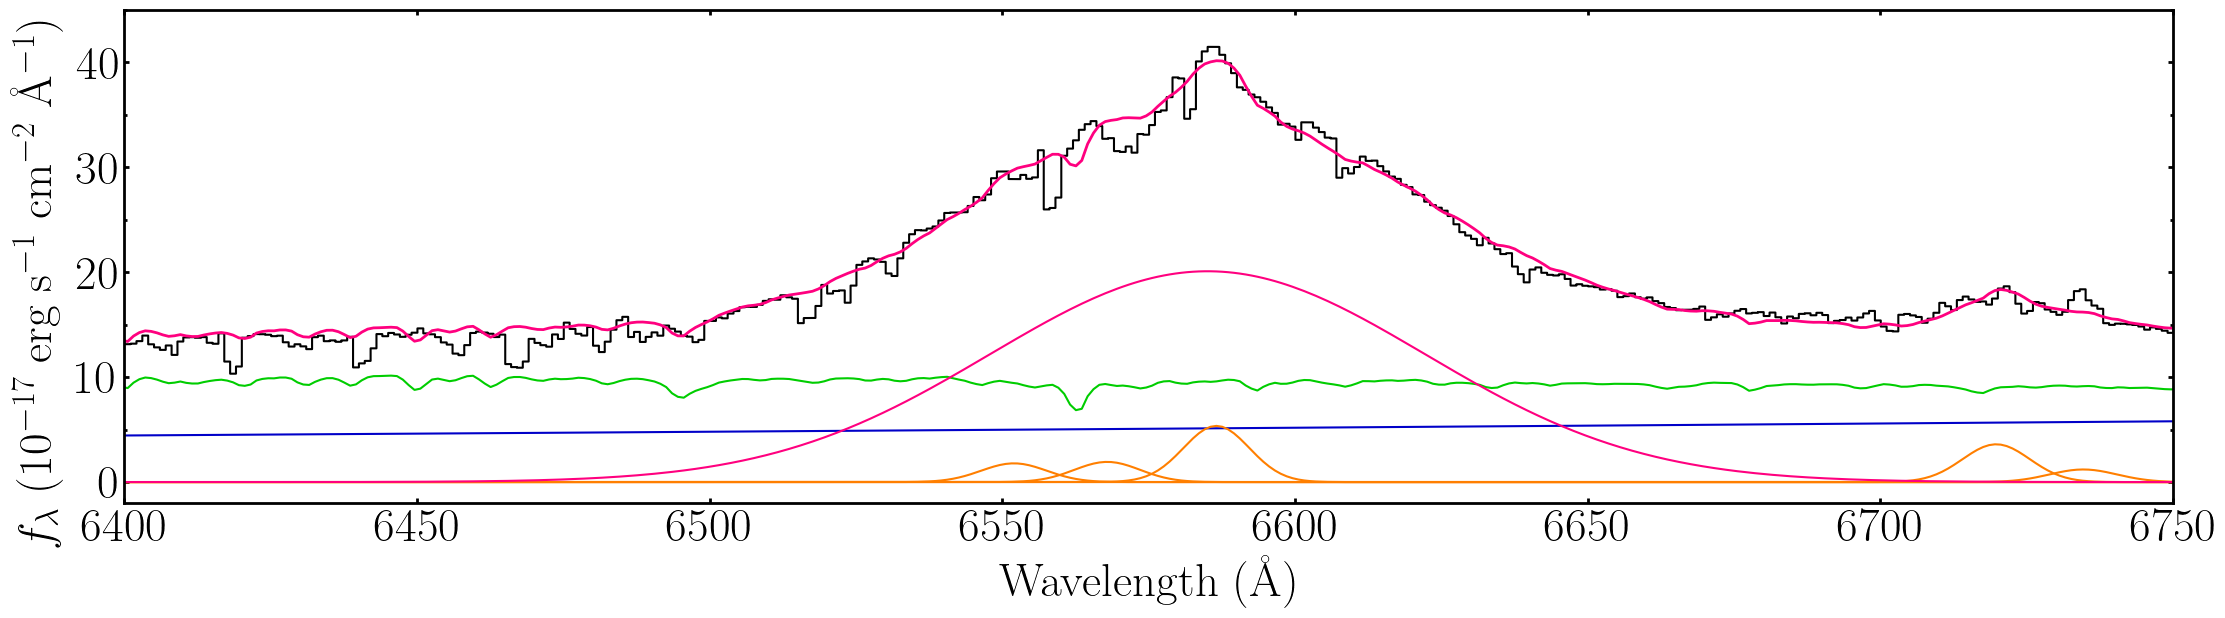

In [84]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength (\AA)'

ylabel = 'f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)'
plotfile = 'halpha'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6400,6750,-2,45,'Wavelength (\AA)',\
                     "$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)",\
                     plotfile,HARDCOPY=True,SHOW=True)


In [47]:
print(spec.specfit.parinfo.values[0: 2])

[0.0004133618889839567, -5.0]


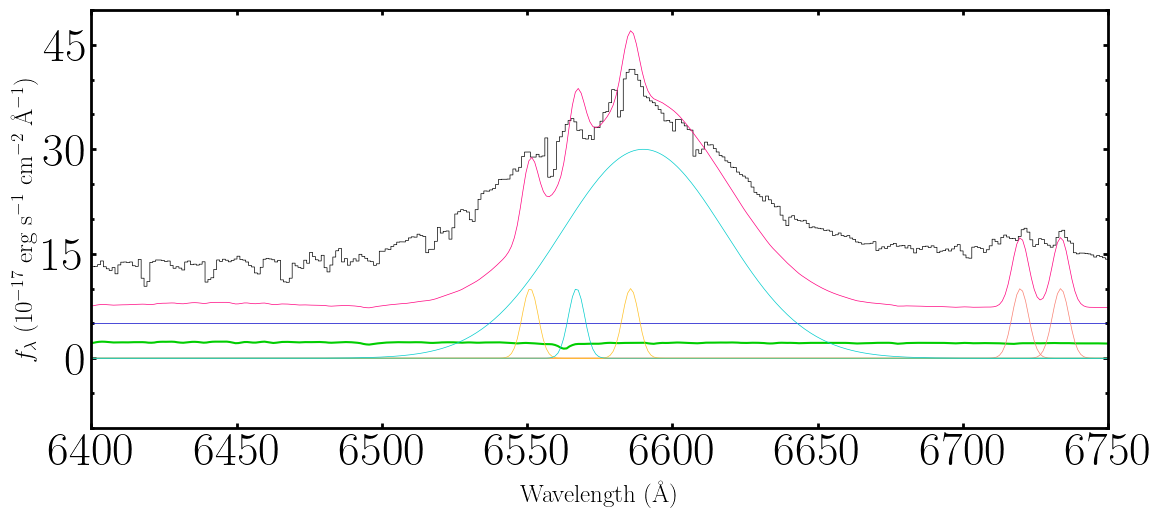

In [48]:
best_model = optical_agn_spectrum(lam,*spec.specfit.guesses,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength (\AA)'

ylabel = 'f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)'
plotfile = 'Figures/halpha'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6400,6750,-10,50,'Wavelength (\AA)',\
                     "$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)",\
                     plotfile,HARDCOPY=False,SHOW=True)


In [ ]:
 Param #14      O3L1_F0 =      15.4726 +/-         4.77539   Range: [0,1e+06],
 Param #15   O3L1_CENT0 =      5007.57 +/-         3.14433   Range:[4960,5100],
 Param #16   O3L1_FWHM0 =      517.725 +/-         314.423   Range: [50,2500],
 Param #17      O3L2_F0 =     0.453438 +/-         7.42143   Range: [0,1e+06],
 Param #18   O3L2_CENT0 =      4999.52 +/-         89.9755   Range:[4960,5100],
 Param #19   O3L2_FWHM0 =      443.522 +/-         8174.39   Range: [50,2500],